# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
import torch
from ddpg_agent import Agent

# make the environment trainable
env_info = env.reset(train_mode=True)[brain_name]

agents = [Agent(state_size=len(env_info.vector_observations[0]), 
                action_size=brain.vector_action_space_size, 
                random_seed=0) 
          for na in range(num_agents)]

In [5]:
def ddpg_one_agent(n_episodes=100, max_t=800):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores, agent

Episode 1	Average Score: 0.14	Score: 0.02
Episode 20	Average Score: 0.12	Score: 0.00

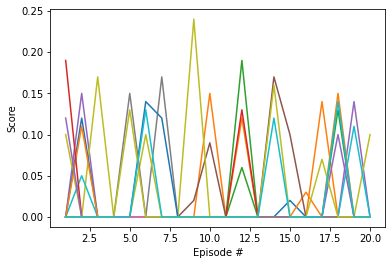

In [6]:
def ddpg(n_episodes=20, max_t=20):
    scores = np.zeros((n_episodes,num_agents)) # initialize the score (for each agent)
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        states = env_info = env.reset(train_mode=True)[brain_name].vector_observations
        for agent in agents:
            agent.reset()
        scores[i_episode-1,:] = np.zeros(num_agents)
        for t in range(max_t):
            actions = []
            for na, agent in enumerate(agents):
                actions.append(agent.act(states[na]))          # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for na, agent in enumerate(agents):
                agent.step(states[na], actions[na], rewards[na], 
                           next_states[na], dones[na])
            states = next_states
            scores[i_episode-1,:] += rewards
            for done in dones:
                if done:
                    break 
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, 
            np.nanmean(np.where(scores>0.01,scores,np.nan)), 
            np.mean(scores[i_episode-1,:])), 
              end="")
        if i_episode-1 % 5 == 0:
            # here we should save all the models...
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, 
                np.nanmean(np.where(scores>0.01,scores,np.nan))))   
    return scores, agent

scores, model = ddpg()

# save model weights
torch.save(agents[2].actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agents[3].critic_local.state_dict(), 'checkpoint_critic.pth')

# plot results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()

## Conclusion

The agent do not achieve the purpose of +30 score over 100 episodes, as I couldnt figure out how to modify the network hyperparameters to achieve so. Nevertheless, I think the code runs correctly, and the architecture of the learning is good. I trained the agent in the Udacity workspace with the GPU enabled, but it didnt work neither...